In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

RANDOM_STATE = 1337
np.random.seed(RANDOM_STATE)


# Adult Income Dataset (UCI): завантаження та первинний аналіз

In [5]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country",
    "income"
]

df = pd.read_csv(
    data_url,
    header=None,
    names=column_names,
    na_values=" ?",
    skipinitialspace=True
)

print("Перші рядки:")
display(df.head())

print("\nНазви колонок:")
print(df.columns.tolist())

print("\nРозмір датасету (рядки, колонки):", df.shape)

print("\nКількість пропусків по колонках:")
print(df.isna().sum())


Перші рядки:


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



Назви колонок:
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

Розмір датасету (рядки, колонки): (32561, 15)

Кількість пропусків по колонках:
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


Перші рядки датасету показують коректно зчитані записи з різнотипними ознаками: числовими (вік, години роботи, фінансові показники) та категоріальними (освіта, сімейний стан, професія, раса, стать, країна). Цільова змінна income має бінарний характер і відображає рівень доходу (<=50K або >50K), що робить датасет придатним для задачі класифікації. Розмір датасету становить 32 561 рядків і 15 колонок, що є достатнім обсягом для навчання та порівняння різних моделей машинного навчання без критичного ризику перенавчання. Такий обсяг даних дозволяє застосовувати як прості алгоритми (kNN), так і більш складні моделі (SVM). Аналіз пропусків показує, що всі колонки не містять значень NaN. Це означає, що на етапі первинного завантаження дані вже очищені від маркерів пропусків або вони були коректно інтерпретовані під час зчитування.

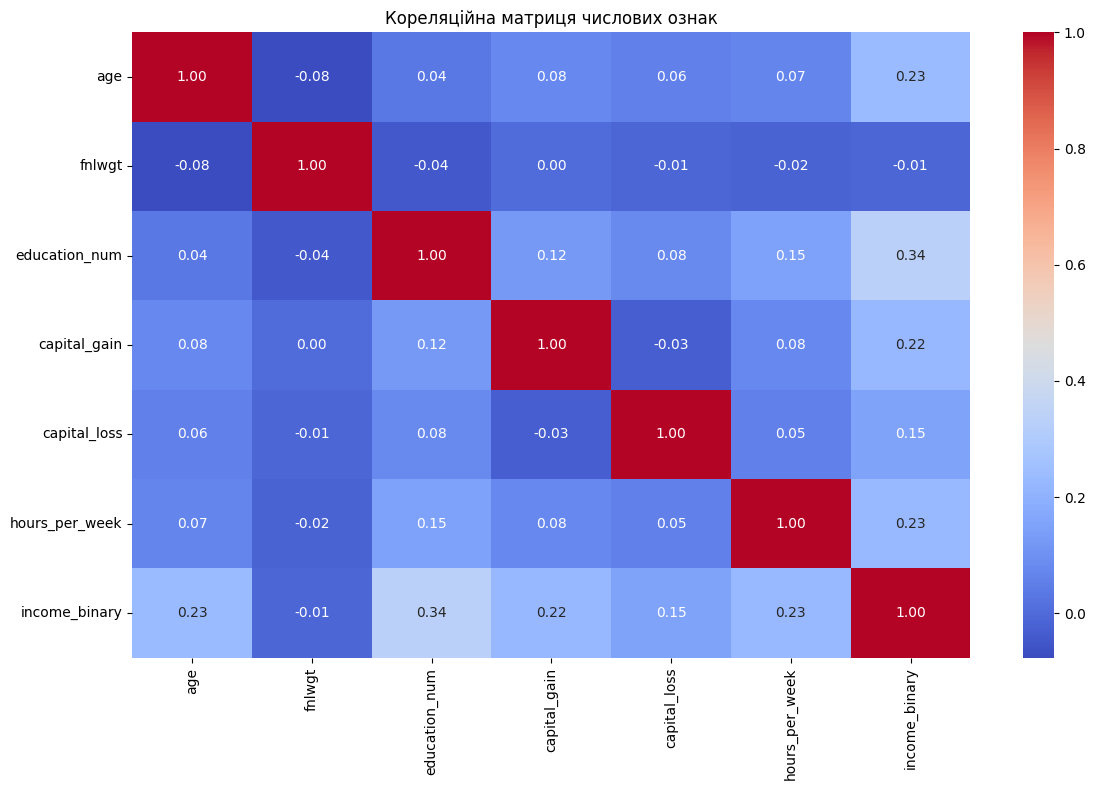

In [6]:
df_viz = df.copy()
df_viz["income_binary"] = (df_viz["income"].str.strip() == ">50K").astype(int)

num_cols = df_viz.select_dtypes(include=["int64", "float64"]).columns.tolist()
if "income_binary" not in num_cols:
    num_cols.append("income_binary")

corr_matrix = df_viz[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Кореляційна матриця числових ознак")
plt.tight_layout()
plt.show()



Кореляція між числовими ознаками та цільовою змінною income_binary загалом є слабкою. Найвищий зв’язок з доходом має education_num (0.34), що вказує на помірну позитивну залежність: зі зростанням рівня освіти зростає ймовірність доходу понад 50K. Ознаки age та hours_per_week мають однакову кореляцію з доходом (по 0.23). Це означає слабкий позитивний зв’язок: старший вік і більша кількість робочих годин підвищують імовірність вищого доходу, але самі по собі ці фактори не є визначальними.

# Візуальний аналіз числових ознак відносно рівня доходу

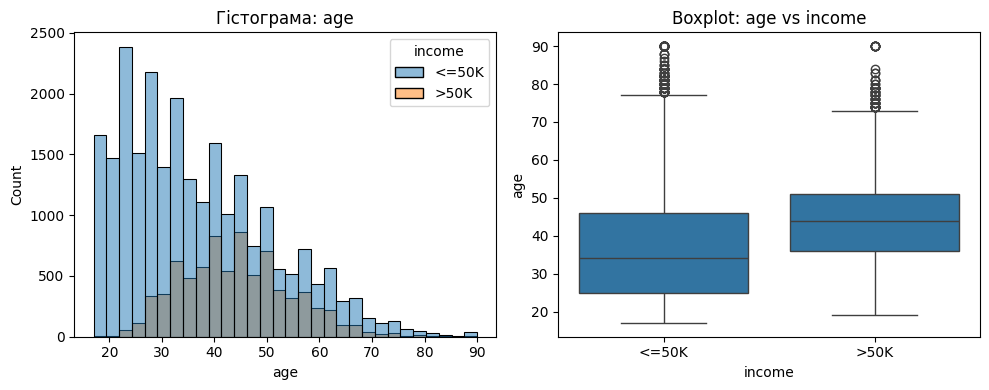

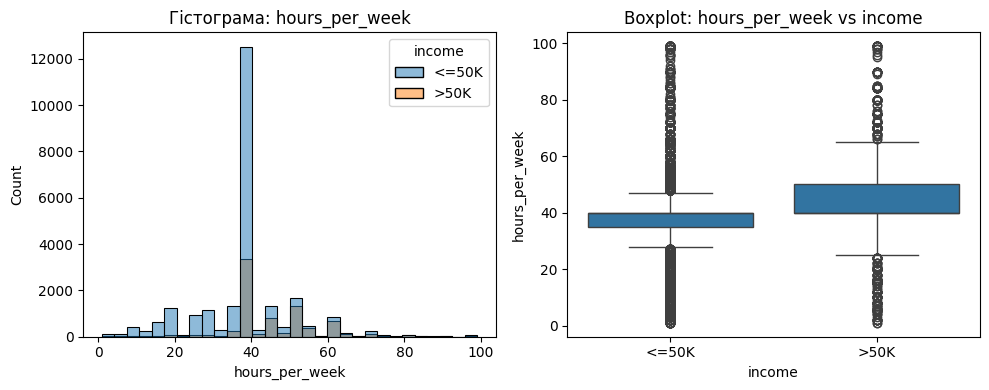

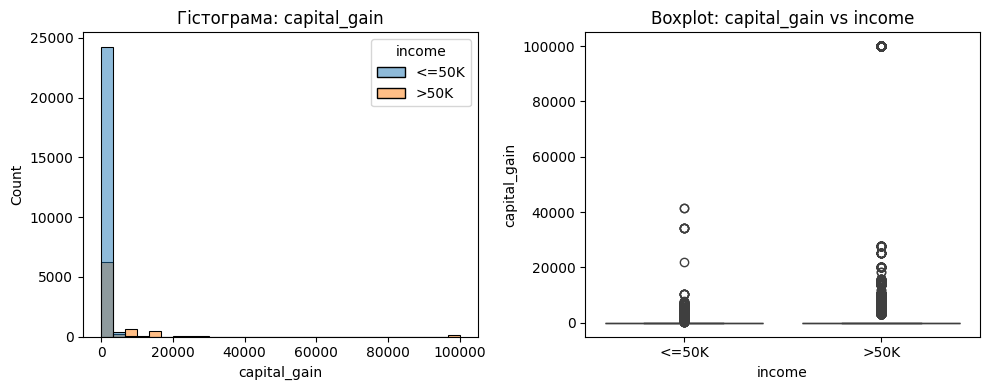

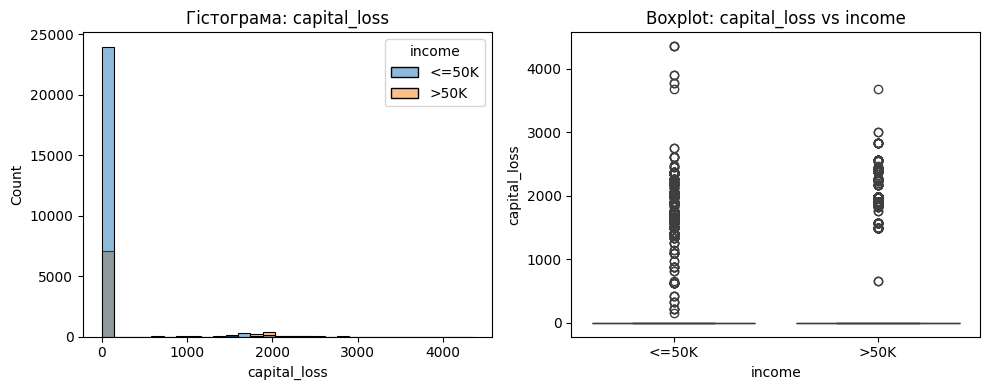

In [7]:
# Вибираємо кілька числових ознак для гістограм і boxplot-ів
features_for_plot = ["age", "hours_per_week", "capital_gain", "capital_loss"]

for col in features_for_plot:
    if col not in df_viz.columns:
        continue

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_viz, x=col, hue="income", kde=False, stat="count", bins=30)
    plt.title(f"Гістограма: {col}")

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_viz, x="income", y=col)
    plt.title(f"Boxplot: {col} vs income")

    plt.tight_layout()
    plt.show()


Гістограма age показує, що більшість спостережень з доходом <=50K зосереджені у віковому діапазоні приблизно 20–40 років. Для групи >50K розподіл зміщений вправо: вищі доходи частіше зустрічаються у старших вікових групах, переважно після 30–35 років. У молодому віці (до ~25 років) випадки доходу понад 50K є поодинокими. Boxplot підтверджує цей зсув розподілів. Медіанний вік для групи >50K помітно вищий, ніж для <=50K.
hours_per_week гістограма показує сильну концентрацію значень навколо 40 годин на тиждень для обох класів доходу, що відповідає стандартному робочому графіку. Для групи >50K розподіл зсунений вправо: частіше трапляються значення 45–60 годин. Boxplot підтверджує, медіана та міжквартильний розмах для >50K вищі, а також більше високих викидів. Більша кількість робочих годин = вища ймовірність високого доходу, але не гарантує його.
capital_gain розподіл є сильно асиметричним з великою масою нульових значень у обох класах. Водночас у групі >50K спостерігається значно більше ненульових і великих значень, що чітко видно на boxplot через численні високі викиди та вищу верхню межу. Це вказує, що капітальні прибутки є сильним індикатором високого доходу, хоча для більшості людей вони відсутні.
capital_loss, аналогічно до capital_gain, більшість значень дорівнює нулю, але ненульові втрати частіше і вищі у групі >50K. Boxplot показує більшу концентрацію викидів і ширший діапазон значень для високих доходів. Це означає, що участь у фінансових операціях (які можуть давати як прибутки, так і втрати) характерніша для осіб з вищим доходом.

# Розділення на тренувальні та тестові данні, та підготовка до навчання


In [9]:
X = df.drop("income", axis=1)
y = (df["income"].str.strip() == ">50K").astype(int)

# Розділяємо числові та категоріальні ознаки
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Числові ознаки:", numeric_features)
print("Категоріальні ознаки:", categorical_features)

# Пайплайни для числових та категоріальних ознак
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Числові ознаки: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Категоріальні ознаки: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Train shape: (26048, 14) Test shape: (6513, 14)


In [10]:
models_and_params = {}

# kNN
models_and_params["KNN"] = (
    KNeighborsClassifier(),
    {
        "model__n_neighbors": [3, 5, 7, 9],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]
    }
)

# Decision Tree
models_and_params["DecisionTree"] = (
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    {
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_leaf": [1, 5, 10]
    }
)

# SVM (RBF) – обов'язковий GridSearch по C та gamma
models_and_params["SVM_RBF"] = (
    SVC(kernel="rbf", probability=False, random_state=RANDOM_STATE),
    {
        "model__C": [0.1, 1.0, 10.0],
        "model__gamma": ["scale", 0.01, 0.1]
    }
)

# Random Forest
models_and_params["RandomForest"] = (
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_leaf": [1, 5]
    }
)

# AdaBoost
models_and_params["AdaBoost"] = (
    AdaBoostClassifier(random_state=RANDOM_STATE),
    {
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.5, 1.0, 1.5]
    }
)

models_and_params


{'KNN': (KNeighborsClassifier(),
  {'model__n_neighbors': [3, 5, 7, 9],
   'model__weights': ['uniform', 'distance'],
   'model__p': [1, 2]}),
 'DecisionTree': (DecisionTreeClassifier(random_state=1337),
  {'model__max_depth': [None, 5, 10, 20],
   'model__min_samples_leaf': [1, 5, 10]}),
 'SVM_RBF': (SVC(random_state=1337),
  {'model__C': [0.1, 1.0, 10.0], 'model__gamma': ['scale', 0.01, 0.1]}),
 'RandomForest': (RandomForestClassifier(n_jobs=-1, random_state=1337),
  {'model__n_estimators': [100, 200],
   'model__max_depth': [None, 10, 20],
   'model__min_samples_leaf': [1, 5]}),
 'AdaBoost': (AdaBoostClassifier(random_state=1337),
  {'model__n_estimators': [50, 100, 200],
   'model__learning_rate': [0.5, 1.0, 1.5]})}

# Перегляд результатів навчання

In [ ]:
best_estimators = {}
cv_results_summary = {}

for name, (model, param_grid) in models_and_params.items():
    print(f"\n=== Модель: {name} ===")

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    print("Найкращі параметри:", grid.best_params_)
    print("Середня CV accuracy:", grid.best_score_)

    best_estimators[name] = grid.best_estimator_
    cv_results_summary[name] = grid.best_score_



=== Модель: KNN ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Найкращі параметри: {'model__n_neighbors': 9, 'model__p': 2, 'model__weights': 'uniform'}
Середня CV accuracy: 0.8366860103710948

=== Модель: DecisionTree ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Найкращі параметри: {'model__max_depth': 10, 'model__min_samples_leaf': 5}
Середня CV accuracy: 0.8515435303359865

=== Модель: SVM_RBF ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Найкращі параметри: {'model__C': 1.0, 'model__gamma': 'scale'}
Середня CV accuracy: 0.8543074311440151

=== Модель: RandomForest ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Найкращі параметри: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}
Середня CV accuracy: 0.8602963791076201

=== Модель: AdaBoost ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Найкращі параметри: {'model__learning_rate': 1.5, 'model__n_estimators': 200}
Середня CV accuracy: 0.8594133363597406


In [ ]:
test_scores = {}

for name, estimator in best_estimators.items():
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    test_scores[name] = acc
    print(f"\n=== {name} – оцінка на тесті ===")
    print("Test accuracy:", acc)

# Найкраща модель за точністю на тесті
best_model_name = max(test_scores, key=test_scores.get)
best_model = best_estimators[best_model_name]

print("\n=== Найкраща модель за тестовою точністю ===")
print(best_model_name, "з accuracy =", test_scores[best_model_name])



=== KNN – оцінка на тесті ===
Test accuracy: 0.8426224474128666

=== DecisionTree – оцінка на тесті ===
Test accuracy: 0.8622754491017964

=== SVM_RBF – оцінка на тесті ===
Test accuracy: 0.860586519269154

=== RandomForest – оцінка на тесті ===
Test accuracy: 0.8682634730538922

=== AdaBoost – оцінка на тесті ===
Test accuracy: 0.8608935974205435

=== Найкраща модель за тестовою точністю ===
RandomForest з accuracy = 0.8682634730538922



############################
Модель: KNN
############################

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4945
           1       0.70      0.61      0.65      1568

    accuracy                           0.84      6513
   macro avg       0.79      0.76      0.78      6513
weighted avg       0.84      0.84      0.84      6513

Confusion matrix:
 [[4529  416]
 [ 609  959]]


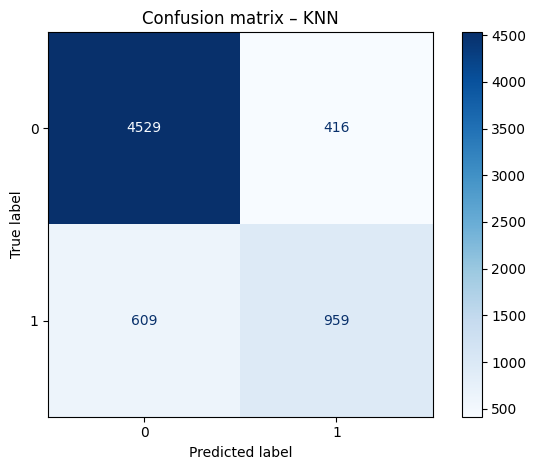


############################
Модель: DecisionTree
############################

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4945
           1       0.77      0.61      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.78      0.80      6513
weighted avg       0.86      0.86      0.86      6513

Confusion matrix:
 [[4652  293]
 [ 604  964]]


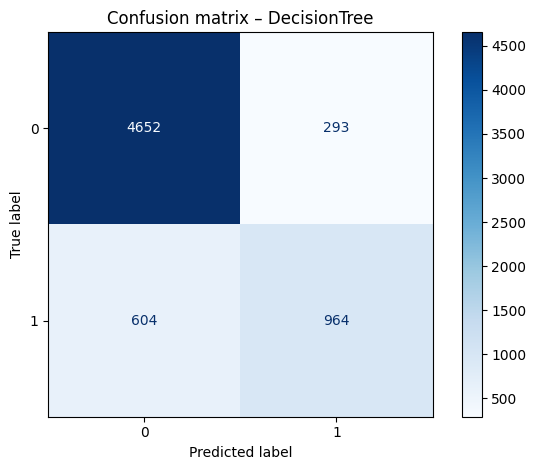


############################
Модель: SVM_RBF
############################

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4945
           1       0.76      0.61      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.80      6513
weighted avg       0.85      0.86      0.86      6513

Confusion matrix:
 [[4643  302]
 [ 606  962]]


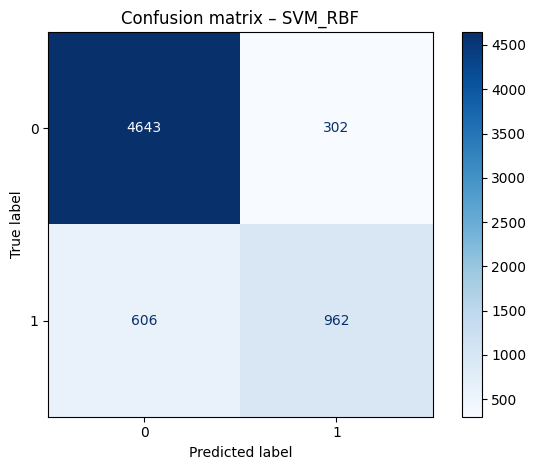


############################
Модель: RandomForest
############################

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4945
           1       0.79      0.62      0.69      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.78      0.81      6513
weighted avg       0.86      0.87      0.86      6513

Confusion matrix:
 [[4682  263]
 [ 595  973]]


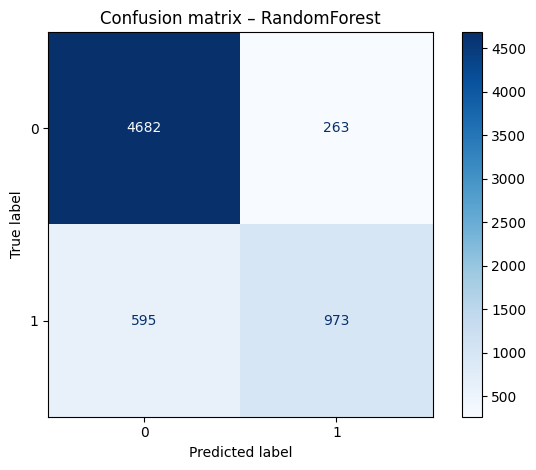


############################
Модель: AdaBoost
############################

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4945
           1       0.76      0.62      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.80      6513
weighted avg       0.86      0.86      0.86      6513

Confusion matrix:
 [[4631  314]
 [ 592  976]]


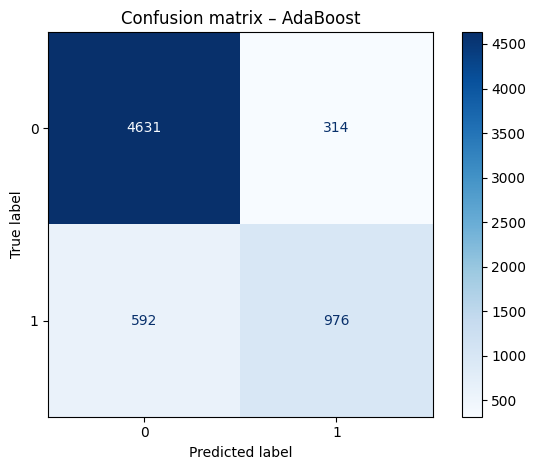


Найкраща модель (за accuracy на тесті): RandomForest


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Зробимо звіт для КОЖНОЇ оптимальної моделі
for name, estimator in best_estimators.items():
    print("\n############################")
    print(f"Модель: {name}")
    print("############################")

    y_pred = estimator.predict(X_test)

    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion matrix – {name}")
    plt.tight_layout()
    plt.show()

# Додатково – ще раз підкреслити найкращу модель
print("\nНайкраща модель (за accuracy на тесті):", best_model_name)


У ході порівняння моделей KNN, Decision Tree, SVM з RBF-ядром, Random Forest та AdaBoost встановлено, що всі алгоритми демонструють близький рівень загальної точності, однак суттєво відрізняються за здатністю коректно виявляти клас високого доходу. Для всіх моделей характерна краща якість класифікації класу <=50K, що пояснюється дисбалансом датасету та більшою кількістю прикладів цього класу.

Найкращі результати показала модель Random Forest, яка досягла найвищої accuracy та F1-score для класу >50K. Вона забезпечує оптимальний баланс між precision і recall, зменшуючи кількість хибних спрацьовувань та пропусків для цільового класу. Інші моделі, зокрема KNN та Decision Tree, поступаються за стабільністю та мають нижчу здатність виявляти осіб з високим рівнем доходу.

Загалом результати свідчать, що ансамблеві методи є більш ефективними для цієї задачі класифікації. Водночас низький recall для класу >50K у всіх моделей вказує на необхідність подальшого покращення, зокрема за рахунок роботи з дисбалансом класів або додаткового налаштування моделей.
